<a href="https://colab.research.google.com/github/dlhegend/-TS_Academy_Capstone_Project/blob/main/notebooks/douglas_tsa_cp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/content/Major_indices.csv')
df.head()

,Date,Price,Index
0,30/01/2012,"20,731.72",NGX ASI
1,31/01/2012,"20,875.83",NGX ASI
2,01/02/2012,"20,790.88",NGX ASI
3,02/02/2012,"20,822.00",NGX ASI
4,03/02/2012,"20,877.64",NGX ASI


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8097 entries, 0 to 8096
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    8094 non-null   object
 1   Price   8094 non-null   object
 2   Index   8094 non-null   object
dtypes: object(3)
memory usage: 189.9+ KB


In [4]:
df.Date = pd.to_datetime(df.Date, format='mixed')
df.set_index('Date', inplace=True)

In [5]:
df.head()

,Price,Index
Date,,
2012-01-30,"20,731.72",NGX ASI
2012-01-31,"20,875.83",NGX ASI
2012-01-02,"20,790.88",NGX ASI
2012-02-02,"20,822.00",NGX ASI
2012-03-02,"20,877.64",NGX ASI


In [6]:
df['Index'].value_counts()

,count
Index,
NGX ASI,2794
S&P/FMDQ SBI,2602
AFEX ACI,1562
USD/NGN,1136


In [7]:
df_ngx = df[df['Index'] == 'NGX ASI'].copy()
df_ngx.head()

,Price,Index
Date,,
2012-01-30,"20,731.72",NGX ASI
2012-01-31,"20,875.83",NGX ASI
2012-01-02,"20,790.88",NGX ASI
2012-02-02,"20,822.00",NGX ASI
2012-03-02,"20,877.64",NGX ASI


In [8]:
df_ngx['Index'].value_counts()

,count
Index,
NGX ASI,2794


In [9]:
df_ngx.drop(columns=['Index'], inplace=True)
df_ngx.head()

,Price
Date,
2012-01-30,"20,731.72"
2012-01-31,"20,875.83"
2012-01-02,"20,790.88"
2012-02-02,"20,822.00"
2012-03-02,"20,877.64"


In [10]:
df_ngx['Price'] = df_ngx['Price'].str.replace(',', '').astype(float)
df_ngx['YearMonth'] = df_ngx.index.to_period('M')
df_monthly_avg = df_ngx.groupby('YearMonth')['Price'].mean().to_frame()
df_monthly_avg.head()

,Price
YearMonth,
2012-01,22069.654286
2012-02,21293.190476
2012-03,21807.626364
2012-04,22238.324211
2012-05,22824.409524


In [11]:
df_monthly_avg.describe()

,Price
count,144.000000
mean,35239.746003
std,8912.656224
min,21293.190476
25%,27719.818842
50%,34161.535455
75%,39917.228967
max,54951.850000


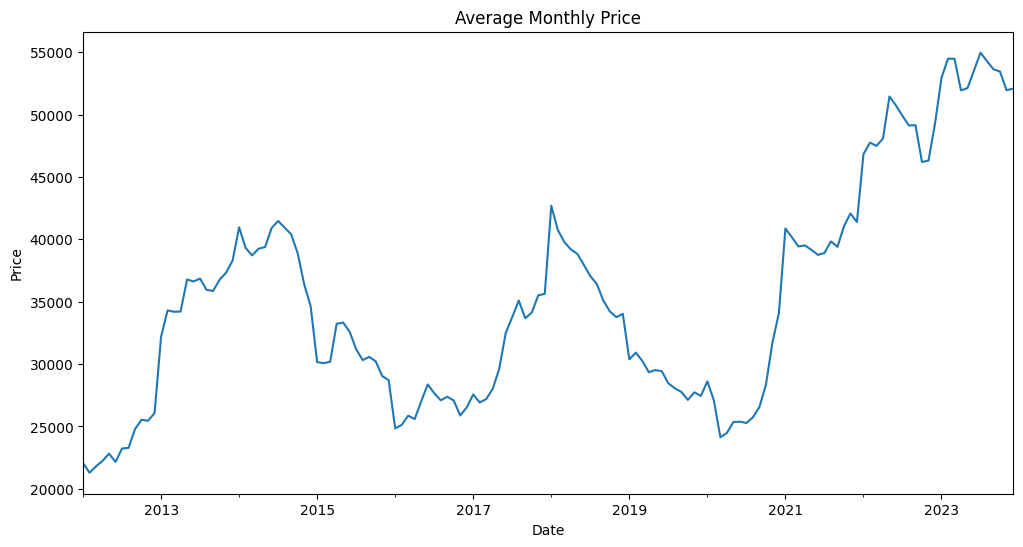

In [12]:
df_monthly_avg['Price'].plot(title='Average Monthly Price',
                             figsize=(12,6))
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

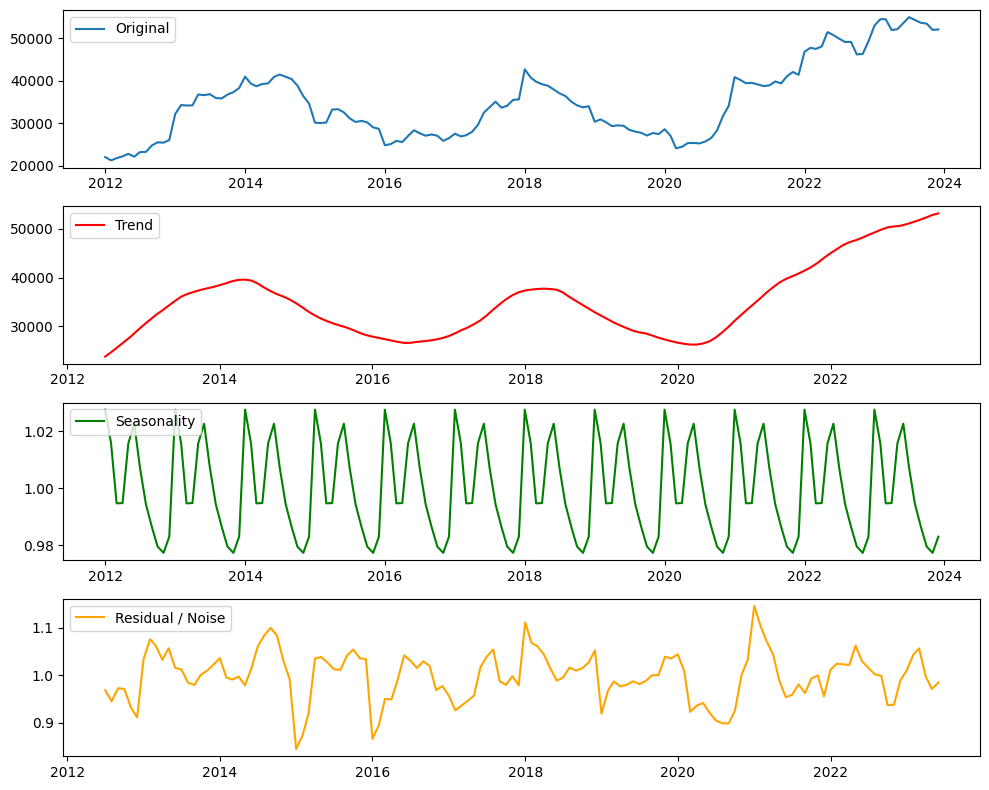

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

df_monthly_avg.index = df_monthly_avg.index.to_timestamp()
decomposition = seasonal_decompose(df_monthly_avg['Price'], model='multiplicative', period=12)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


plt.figure(figsize=(10,8))

plt.subplot(4,1,1)
plt.plot(df_monthly_avg['Price'], label='Original')
plt.legend(loc='upper left')

plt.subplot(4,1,2)
plt.plot(trend, label='Trend', color='red')
plt.legend(loc='upper left')

plt.subplot(4,1,3)
plt.plot(seasonal, label='Seasonality', color='green')
plt.legend(loc='upper left')

plt.subplot(4,1,4)
plt.plot(residual, label='Residual / Noise', color='orange')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [14]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(df_monthly_avg['Price'])

print(f'ADF Statistic: {adf_result[0]:.4f}')
print(f'p-value: {adf_result[1]:.4f}')
if adf_result[1] < 0.05:
    print("The series is likely stationary")
else:
    print("The series is likely non-stationary")

ADF Statistic: -1.2368
p-value: 0.6576
The series is likely non-stationary


In [15]:
from statsmodels.tsa.stattools import kpss

kpss_result = kpss(df_monthly_avg['Price'], regression='c', nlags='auto')

print(f'KPSS Statistic: {kpss_result[0]:.4f}')
print(f'p-value: {kpss_result[1]:.4f}')

# KPSS test null hypothesis: The series is stationary around a deterministic trend
# If p-value < 0.05, reject the null hypothesis (series is non-stationary)
# If p-value >= 0.05, fail to reject the null hypothesis (series is stationary)
if kpss_result[1] < 0.05:
    print("The series is likely non-stationary (reject H0)")
else:
    print("The series is likely stationary (fail to reject H0)")

KPSS Statistic: 0.7140
p-value: 0.0123
The series is likely non-stationary (reject H0)


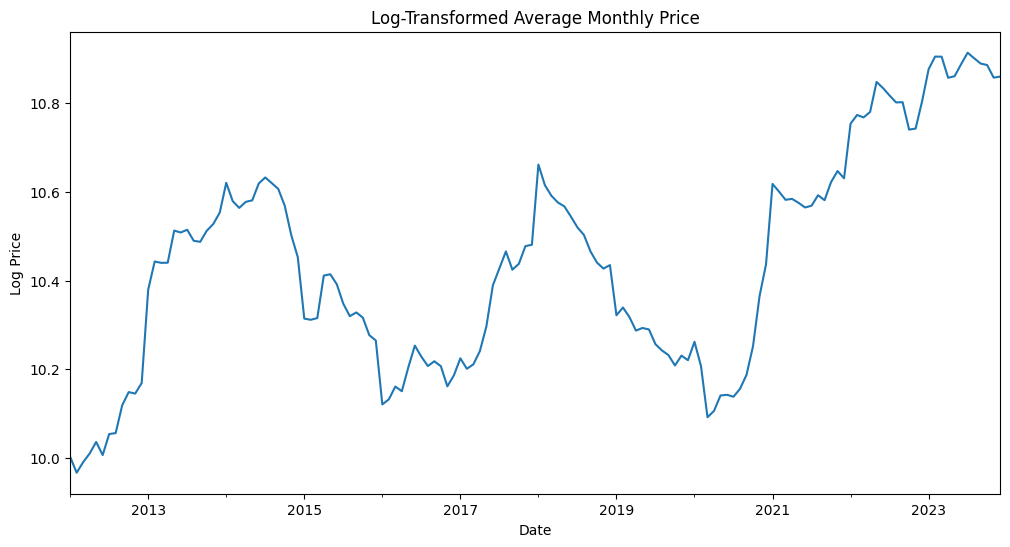

In [16]:
import numpy as np

df_monthly_avg['log_price'] = np.log(df_monthly_avg['Price'])

plt.figure(figsize=(12,6))
df_monthly_avg['log_price'].plot(title='Log-Transformed Average Monthly Price')
plt.xlabel('Date')
plt.ylabel('Log Price')
plt.show()

In [17]:
def test_stationarity(series):
    print("--- ADF Test Results ---")
    result_adf = adfuller(series)
    print(f'ADF Statistic: {result_adf[0]:.4f}')
    print(f'p-value: {result_adf[1]:.4f}')
    print('Critical Values:', result_adf[4])
    if result_adf[1] < 0.05:
        print("Conclusion: Reject H0, series is likely stationary (no unit root).")
    else:
        print("Conclusion: Fail to reject H0, series is likely non-stationary (has a unit root).")

    print("\n--- KPSS Test Results ---")
    result_kpss = kpss(series, regression='c', nlags='auto')
    print(f'KPSS Statistic: {result_kpss[0]:.4f}')
    print(f'p-value: {result_kpss[1]:.4f}')
    print('Critical Values:', result_kpss[3])
    # KPSS test null hypothesis: The series is stationary around a deterministic trend (or mean)
    if result_kpss[1] < 0.05:
        print("Conclusion: Reject H0, series is likely non-stationary (not stationary around a deterministic trend).")
    else:
        print("Conclusion: Fail to reject H0, series is likely stationary (stationary around a deterministic trend).")

    print("\n--- Combined Test Conclusions ---")
    # Interpret combined results
    adf_stationary = result_adf[1] < 0.05
    kpss_stationary = result_kpss[1] >= 0.05

    if adf_stationary and kpss_stationary:
        print("The series is likely stationary (both tests agree).")
    elif not adf_stationary and not kpss_stationary:
        print("The series is likely non-stationary (both tests agree).")
    elif adf_stationary and not kpss_stationary:
        print("Conflicting results: ADF suggests stationarity, KPSS suggests non-stationarity. The series might be difference stationary but requires more differencing or might have a structural break.")
    elif not adf_stationary and kpss_stationary:
        print("Conflicting results: ADF suggests non-stationarity, KPSS suggests stationarity. The series might be trend-stationary.")

In [18]:
test_stationarity(df_monthly_avg['log_price'])

--- ADF Test Results ---
ADF Statistic: -1.6828
p-value: 0.4400
Critical Values: {'1%': np.float64(-3.477261624048995), '5%': np.float64(-2.8821181874544233), '10%': np.float64(-2.5777431104939494)}
Conclusion: Fail to reject H0, series is likely non-stationary (has a unit root).

--- KPSS Test Results ---
KPSS Statistic: 0.6490
p-value: 0.0182
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Conclusion: Reject H0, series is likely non-stationary (not stationary around a deterministic trend).

--- Combined Test Conclusions ---
The series is likely non-stationary (both tests agree).


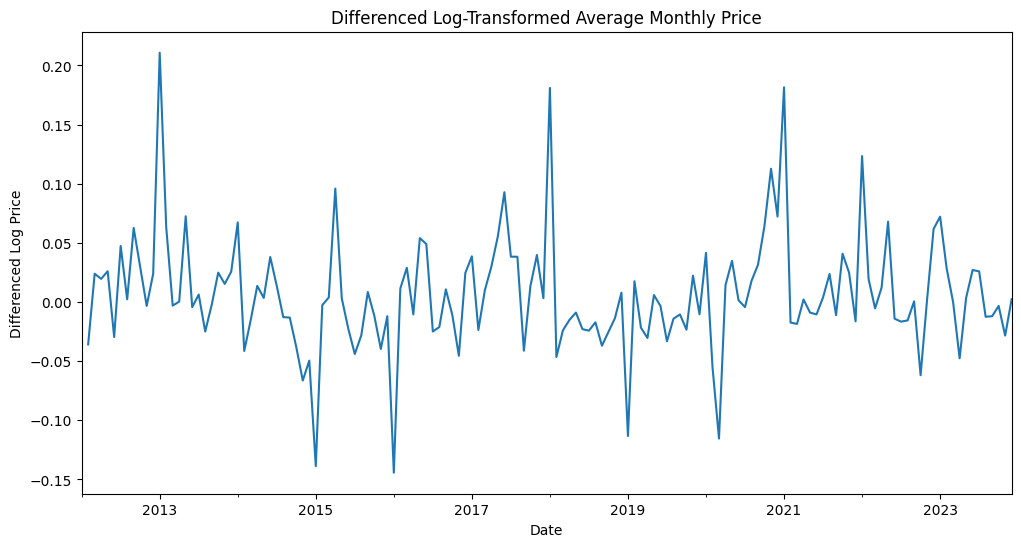

In [19]:
df_monthly_avg['diff_log_price'] = df_monthly_avg['log_price'].diff()

plt.figure(figsize=(12,6))
df_monthly_avg['diff_log_price'].plot(title='Differenced Log-Transformed Average Monthly Price')
plt.xlabel('Date')
plt.ylabel('Differenced Log Price')
plt.show()

In [20]:
test_stationarity(df_monthly_avg['diff_log_price'].dropna())

--- ADF Test Results ---
ADF Statistic: -9.5311
p-value: 0.0000
Critical Values: {'1%': np.float64(-3.477261624048995), '5%': np.float64(-2.8821181874544233), '10%': np.float64(-2.5777431104939494)}
Conclusion: Reject H0, series is likely stationary (no unit root).

--- KPSS Test Results ---
KPSS Statistic: 0.1001
p-value: 0.1000
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Conclusion: Fail to reject H0, series is likely stationary (stationary around a deterministic trend).

--- Combined Test Conclusions ---
The series is likely stationary (both tests agree).


/tmp/ipython-input-2009061419.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result_kpss = kpss(series, regression='c', nlags='auto')


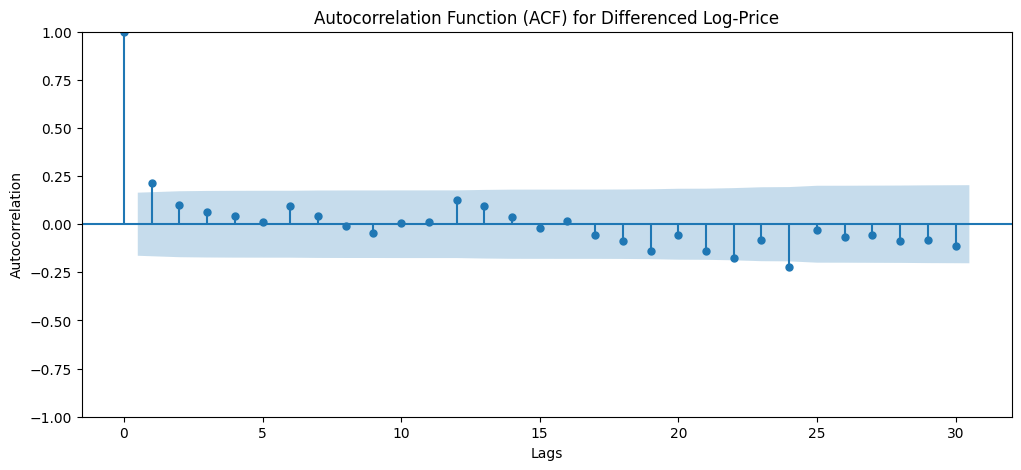

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create ACF plot
plt.figure(figsize=(12, 5))
plot_acf(df_monthly_avg['diff_log_price'].dropna(), lags=30, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) for Differenced Log-Price')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

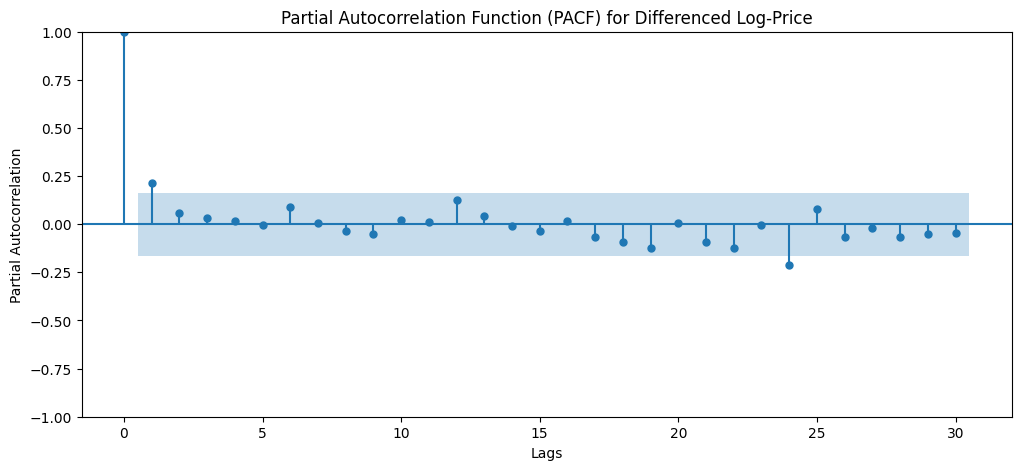

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create PACF plot
plt.figure(figsize=(12, 5))
plot_pacf(df_monthly_avg['diff_log_price'].dropna(), lags=30, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) for Differenced Log-Price')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.show()

In [23]:
train_size = int(len(df_monthly_avg) * 0.8)

train = df_monthly_avg['log_price'][:train_size]
test = df_monthly_avg['log_price'][train_size:]

In [24]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train, order=(1, 1, 1))
fitted_model = model.fit()

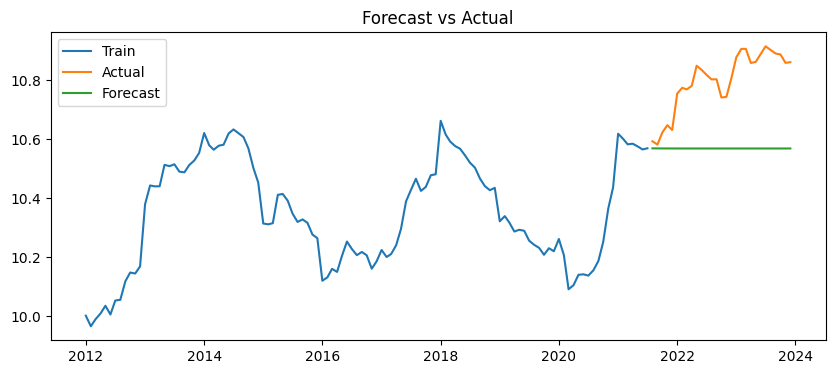

In [25]:
forecast_1 = fitted_model.forecast(steps=len(test))

plt.figure(figsize=(10,4))
plt.plot(train, label='Train')
plt.plot(test, label='Actual')
plt.plot(forecast_1, label='Forecast')
plt.legend()
plt.title("Forecast vs Actual")
plt.show()

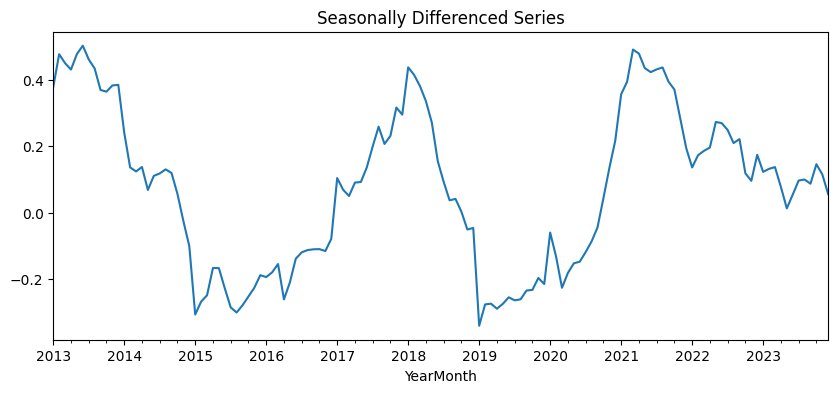

In [26]:
df_monthly_avg['Seasonal_Diff'] = df_monthly_avg['log_price'] - df_monthly_avg['log_price'].shift(12)
df_seasonal = df_monthly_avg['Seasonal_Diff'].dropna()

df_seasonal.plot(title="Seasonally Differenced Series", figsize=(10,4))
plt.show()

In [27]:
test_stationarity(df_seasonal)

--- ADF Test Results ---
ADF Statistic: -3.3874
p-value: 0.0114
Critical Values: {'1%': np.float64(-3.484219653271961), '5%': np.float64(-2.885145235641637), '10%': np.float64(-2.579359138917794)}
Conclusion: Reject H0, series is likely stationary (no unit root).

--- KPSS Test Results ---
KPSS Statistic: 0.1660
p-value: 0.1000
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Conclusion: Fail to reject H0, series is likely stationary (stationary around a deterministic trend).

--- Combined Test Conclusions ---
The series is likely stationary (both tests agree).


/tmp/ipython-input-2009061419.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result_kpss = kpss(series, regression='c', nlags='auto')


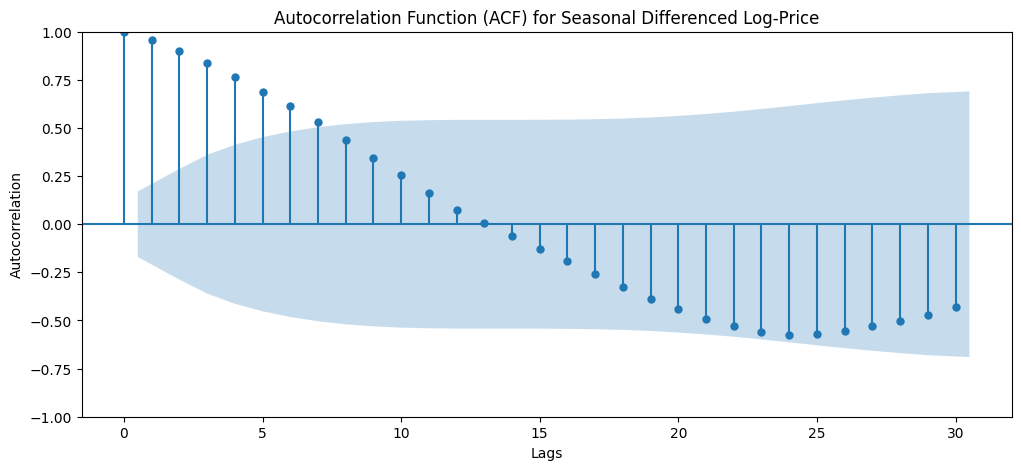

In [28]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create ACF plot
plt.figure(figsize=(12, 5))
plot_acf(df_seasonal, lags=30, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) for Seasonal Differenced Log-Price')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

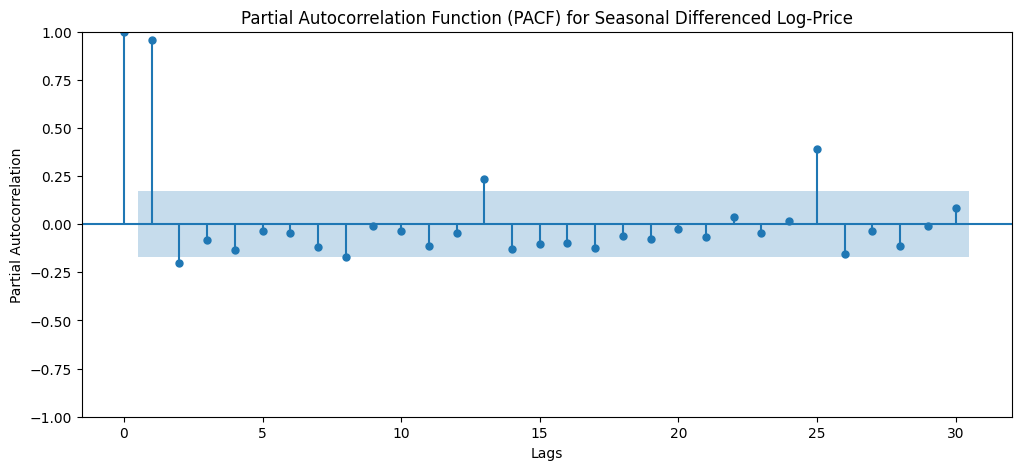

In [29]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create PACF plot
plt.figure(figsize=(12, 5))
plot_pacf(df_seasonal, lags=30, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) for Seasonal Differenced Log-Price')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.show()

In [30]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    train,
    order=(1,1,1),
    seasonal_order=(1,1,1,12)
)

results = model.fit()

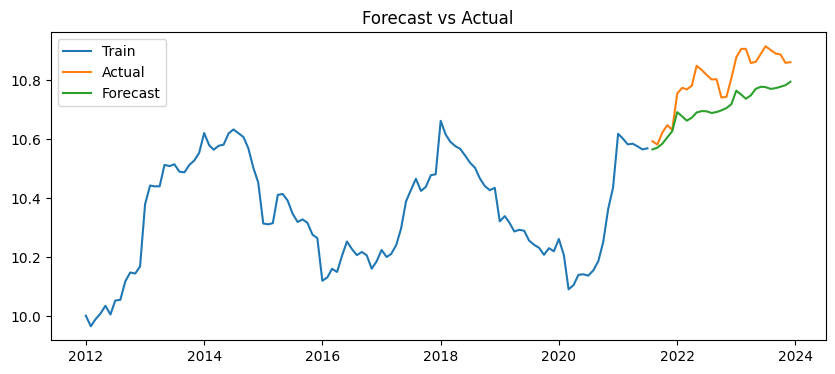

In [31]:
forecast_2 = results.forecast(steps=len(test))

plt.figure(figsize=(10,4))
plt.plot(train, label='Train')
plt.plot(test, label='Actual')
plt.plot(forecast_2, label='Forecast')
plt.legend()
plt.title("Forecast vs Actual")
plt.show()

In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
test_expon = np.exp(test)
forecast_expon = np.exp(forecast_2)

mae = mean_absolute_error(test_expon, forecast_expon)
mape = mean_absolute_percentage_error(test_expon, forecast_expon)
mse = mean_squared_error(test_expon, forecast_expon)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {(mape * 100):.2f}%')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

Mean Absolute Error (MAE): 4480.76
Mean Absolute Percentage Error (MAPE): 8.79%
Mean Squared Error (MSE): 25048506.15
Root Mean Squared Error (RMSE): 5004.85
